# Лабораторная №4

#### Задание:

1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите следующие модели:
    - одну из линейных моделей;
    - SVM;
    - дерево решений.
5. Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.

#### Дополнительные задания:

1. Проведите эксперименты с важностью признаков в дереве решений.
2. Визуализируйте дерево решений.

In [1]:
from IPython.display import Image
from io import StringIO
import graphviz
import pydotplus

import numpy as np
import pandas as pd
import math

import seaborn as sns
sns.set(style="ticks")

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

from sklearn.tree import export_graphviz

In [3]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.2, a-0.1, str(round(b,3)), color='white')
        plt.show()    

In [4]:
data = pd.read_csv("SolarPrediction.csv")

## Предобработка данных

In [46]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [7]:
data.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


Рассмотрим влияние времени на радиацию

In [23]:
data['data_time'] = pd.to_datetime(data['Data'].str.split(' ', expand=True).iloc[:,0] + ' '+ data['Time'])

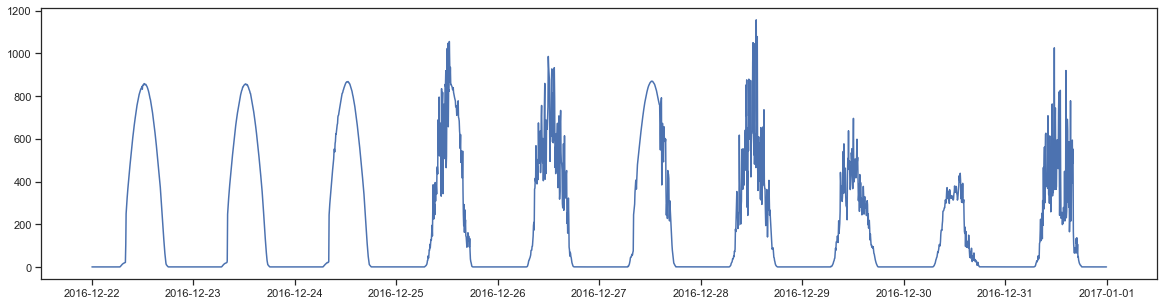

In [37]:
aux = data[data['data_time'] > pd.to_datetime('2016-12-22')]

fig, ax = plt.subplots(figsize=(20,5)) 
plt.plot(aux['data_time'], aux['Radiation'])
ax.set_title('Радиация по времени')

Заметны ежедневные колебания радиации в зависимости от времени суток, так что можем выделить только эту информацию.

In [21]:
data["Time"] = data.Time.str.slice(stop=2).astype(int)

In [22]:
data["Morning"] = (data["Time"] >= 6) & (data["Time"] <= 12)
data["Afternoon"] = (data["Time"] >= 13) & (data["Time"] <= 19)
data["Night"] = (data["Time"] >= 20) & (data["Time"] <= 23)
data["EarlyMorning"] = (data["Time"] >= 0) & (data["Time"] <= 5)

In [23]:
from sklearn.preprocessing import LabelEncoder

lab_enc = LabelEncoder()
data['Morning'] = lab_enc.fit_transform(data['Morning'])
data['Afternoon'] = lab_enc.fit_transform(data['Afternoon'])
data['Night'] = lab_enc.fit_transform(data['Night'])
data['EarlyMorning'] = lab_enc.fit_transform(data['EarlyMorning'])

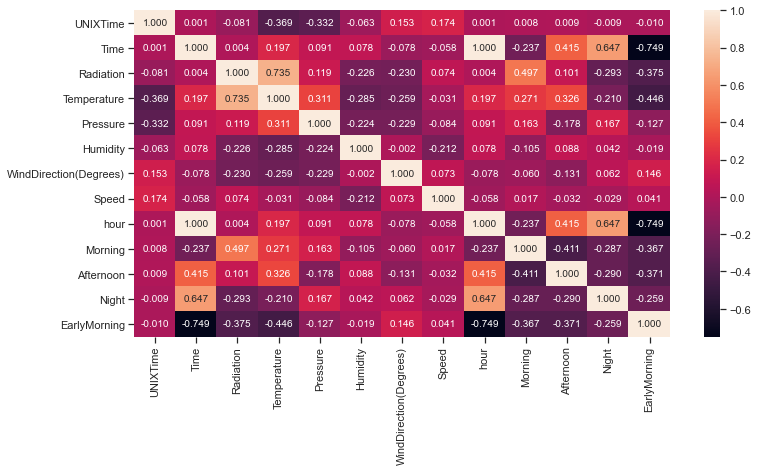

In [59]:
corrmat = data.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corrmat, annot=True, fmt='.3f')

Учитывая информацию о корреляции признаков с целевым (радиацией), разделим выборку на обучающую и тестовую

In [24]:
%%capture
y = data['Radiation']
X = data[['Temperature','Pressure', 'Humidity', 'WindDirection(Degrees)', 'Morning', 'Afternoon', 'Night', 'EarlyMorning']]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [26]:
metrics = MetricLogger()

## Линейная модель

In [73]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [116]:
y_pred_linear = model.predict(X_test)

RMSE = mean_squared_error(y_test, y_pred_linear, squared=False)
MAE = mean_absolute_error(y_test, y_pred_linear)
R2_Score = r2_score(y_test, y_pred_linear)
MedAE = median_absolute_error(y_test, y_pred_linear)

metrics.add('RMSE', 'Linear Regression', RMSE)
metrics.add('MAE', 'Linear Regression', MAE)
metrics.add('R2 Score', 'Linear Regression', R2_Score)
metrics.add('Median AE', 'Linear Regression', MedAE)

print('RMSE =', RMSE)
print('MAE =', MAE)
print('R2 Score =', R2_Score)
print ("Median AE =", MedAE) # 0 - лучшее значение

RMSE = 183.71440040226548
MAE = 139.74836818158906
R2 Score = 0.6628141270214678
Median AE = 108.58990730244786


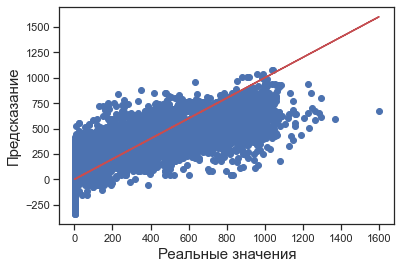

In [75]:
plt.scatter(y_test, y_pred_linear)  
plt.plot(y_test, y_test, 'r') 
plt.xlabel('Реальные значения', fontsize = 15)  
plt.ylabel('Предсказание', fontsize = 15)  
plt.show()

## SVM

In [ ]:
svr = SVR(kernel='rbf', C=1000.0)
svr.fit(X_train, y_train)

y_pred_svr = svr.predict(X_test)

In [ ]:
RMSE = mean_squared_error(y_test, y_pred_svr, squared=False)
MAE = mean_absolute_error(y_test, y_pred_svr)
R2_Score = r2_score(y_test, y_pred_svr)
MedAE = median_absolute_error(y_test, y_pred_svr)

metrics.add('RMSE', 'SVR', RMSE)
metrics.add('MAE', 'SVR', MAE)
metrics.add('R2 Score', 'SVR', R2_Score)
metrics.add('Median AE', 'SVR', MedAE)

print('RMSE =', RMSE)
print('MAE =', MAE)
print('R2 Score =', R2_Score)
print ("Median AE =", MedAE) # 0 - лучшее значение

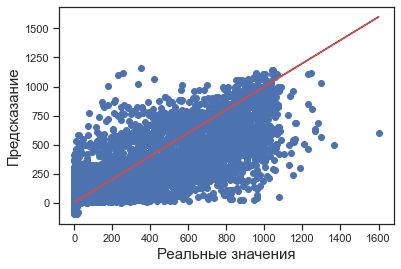

In [87]:
plt.scatter(y_test, y_pred_svr)  
plt.plot(y_test, y_test, 'r') 
plt.xlabel('Реальные значения', fontsize = 15)  
plt.ylabel('Предсказание', fontsize = 15)  
plt.show()

## Дерево решений

In [241]:
tree = DecisionTreeRegressor(random_state=23)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

In [242]:
RMSE = mean_squared_error(y_test, y_pred_tree, squared=False)
MAE = mean_absolute_error(y_test, y_pred_tree)
R2_Score = r2_score(y_test, y_pred_tree)
MedAE = median_absolute_error(y_test, y_pred_tree)


metrics.add('RMSE', 'Decision Tree', RMSE)
metrics.add('MAE', 'Decision Tree', MAE)
metrics.add('R2 Score', 'Decision Tree', R2_Score)
metrics.add('Median AE', 'Decision Tree', MedAE)

print('RMSE =', RMSE)
print('MAE =', MAE)
print('R2 Score =', R2_Score) # 1 - лучшее
print ("Median AE =", MedAE) # 0 - лучшее

RMSE = 161.22134759760834
MAE = 70.68609243508645
R2 Score = 0.7403262406816951
Median AE = 1.5700000000000003


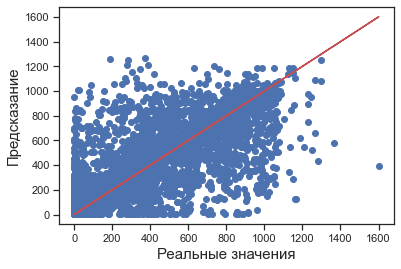

In [88]:
plt.scatter(y_test, y_pred_tree)  
plt.plot(y_test, y_test, 'r') 
plt.xlabel('Реальные значения', fontsize = 15)  
plt.ylabel('Предсказание', fontsize = 15)  
plt.show()

In [214]:
features = ['Temperature','Pressure', 'Humidity', 'Morning', 'Afternoon', 'Night', 'EarlyMorning']

In [234]:
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

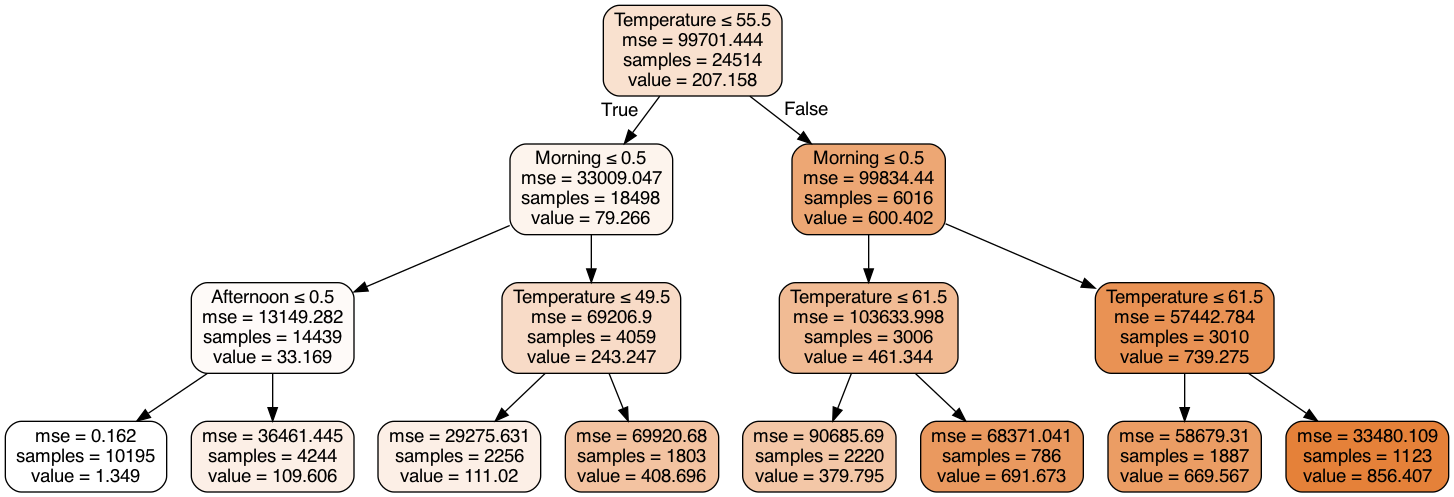

In [240]:
Image(get_png_tree(tree, features), width='80%')

Важность признаков

In [105]:
list(zip(features, reg.feature_importances_))

[('Temperature', 0.6624176426693815),
 ('Pressure', 0.08179001615319866),
 ('Humidity', 0.13000493922461095),
 ('Morning', 0.11061342723451908),
 ('Afternoon', 0.015173786231224225),
 ('Night', 1.7539775096270733e-07),
 ('EarlyMorning', 1.3089314408436572e-08)]

In [106]:
from operator import itemgetter

list_to_sort = list(zip(features, reg.feature_importances_))
sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
labels = [x for x,_ in sorted_list]

In [107]:
labels

['Temperature',
 'Humidity',
 'Morning',
 'Pressure',
 'Afternoon',
 'Night',
 'EarlyMorning']

In [110]:
mae_list = []

reg = DecisionTreeRegressor(random_state = 42)
for i in range(1, len(labels)+1):
    reg.fit(X_train[labels[0:i]], y_train)
    y_pred_tree2 = reg.predict(X_test[labels[0:i]])
    
    temp_mae = mean_absolute_error(y_pred_tree2, y_test)
    mae_list.append(temp_mae)

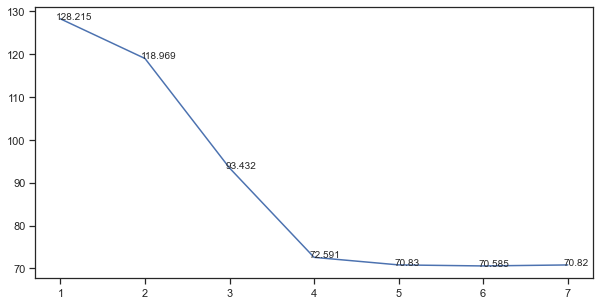

In [111]:
plt.subplots(figsize=(10,5))
plt.plot(range(1, len(labels)+1), mae_list)
for a,b in zip(range(1, len(labels)+1), mae_list):
    plt.text(a-0.05, b+0.01, str(round(b,3)))
plt.show()

In [113]:
reg = DecisionTreeRegressor(random_state = 42)

reg.fit(X_train[labels[0:1]], y_train)
y_pred_tree2 = reg.predict(X_test[labels[0:1]])

In [114]:
RMSE = mean_squared_error(y_test, y_pred_linear, squared=False)
MAE = mean_absolute_error(y_test, y_pred_linear)
R2_Score = r2_score(y_test, y_pred_linear)
MedAE = median_absolute_error(y_test, y_pred_linear)

print('RMSE =', RMSE)
print('MAE =', MAE)
print('R2 Score =', R2_Score) # 1 - лучшее
print ("Median AE =", MedAE) # 0 - лучшее

RMSE = 183.6450577090526
MAE = 139.7675386592176
R2 Score = 0.6630686194713111
Median AE = 108.23153722285949


## Сравнение качества полученных моделей

In [119]:
clas_metrics = metrics.df['metric'].unique()
clas_metrics

array(['RMSE', 'MAE', 'R2 Score', 'Median AE'], dtype=object)

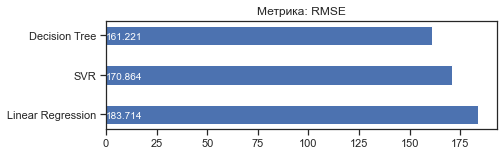

In [122]:
metrics.plot('Метрика: ' + 'RMSE', 'RMSE', ascending=False, figsize=(7, 2))

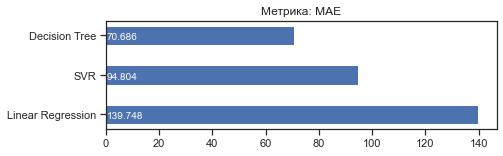

In [123]:
metrics.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 2))

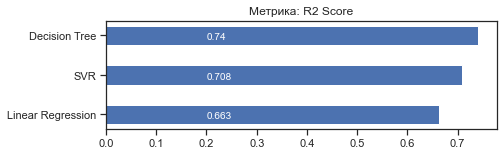

In [124]:
metrics.plot('Метрика: ' + 'R2 Score', 'R2 Score', ascending=True, figsize=(7, 2))

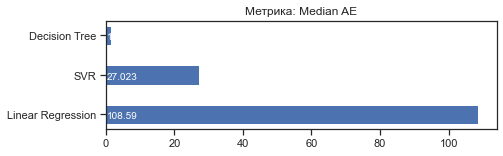

In [125]:
metrics.plot('Метрика: ' + 'Median AE', 'Median AE', ascending=False, figsize=(7, 2))

Лучшей оказалась модель Decision Tree

# Лабораторная №5

#### Задание:

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите две ансамблевые модели. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

## Градиентный бустинг

In [194]:
from sklearn.ensemble import GradientBoostingRegressor

In [195]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [197]:
gb_score = reg.score(X_test, y_test)    #R2
gb_score

0.7631290360315247

In [143]:
boost_prediction = reg.predict(X_test)

In [146]:
print('mean absolute error =', mean_absolute_error(y_test, boost_prediction))

mean absolute error = 65.7936654175928


## Stacking and blending 

In [150]:
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

In [151]:
dataset = Dataset(X_train, y_train, X_test)

# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')
model_svr = Regressor(dataset=dataset, estimator=SVR, parameters={'kernel': 'rbf', 'gamma': 0.001, 'C': 1000.0}, name = 'svr')

model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')

In [153]:
pipeline = ModelsPipeline(model_tree, model_lr, model_svr, model_rf)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=r2_score)

Metric: r2_score
Folds accuracy: [0.8218942037642474, 0.8291350275695792, 0.8102931798323086, 0.8082570039751233, 0.8280857545390783, 0.8128446419364532, 0.8050669575457489, 0.8147181564716821, 0.8170559846925569, 0.802330567384455]
Mean accuracy: 0.8149681477711234
Standard Deviation: 0.00868510195703396
Variance: 7.543099600407513e-05


## Сравнение качества полученных моделей

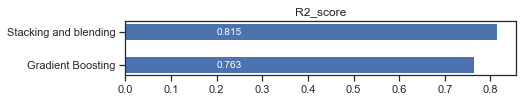

In [205]:
array_labels = ['Gradient Boosting', 'Stacking and blending']
array_metric = [gb_score, 0.815]
fig, ax1 = plt.subplots(figsize=(7, 1))
pos = np.arange(len(array_metric))
rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
ax1.set_title('R2_score')
for a,b in zip(pos, array_metric):
    plt.text(0.2, a-0.1, str(round(b,3)), color='white')
plt.show()   

Модель стекинга и бустинга показала лучшие результаты